# Processing & Analysis of Biotek Plate Reader Records

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import string
import mwc.bayes
import mwc.stats
import mwc.viz
import mwc.fitderiv
import bebi103.viz
import pystan
import tqdm
colors = mwc.viz.personal_style()
alt.data_transformers.enable('json')
%load_ext stanmagic

In [2]:
# Load the data. 
data = pd.read_csv('../../../../data/20190121_37C_glucose_O2_growth_plate.csv')

# Prune the nans
data.dropna(inplace=True)

# Conver the time to minutes
time = pd.DatetimeIndex(data['Time'])
time_min = time.hour * 60 + time.minute + time.second/60
data['Time'] = time_min

# Rename columns for simplicity
data.rename(columns={'Time':'time_min', 'Ti OD600:600':'temp_C'}, inplace=True)

# Melt to longform tidy
data = data.melt(id_vars=['time_min', 'temp_C'])

# Rename variable and value vars.
data.rename(columns={'variable':'well_id', 'value':'od_600nm'}, inplace=True)

# Rename well id to well number. 
alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}

# Rename well ids to numeral.
data['well_id'] = [alphanumeric_map[a] for a in data['well_id'].values]


# Include strain IDs.
strain_wells = {alphanumeric_map[f'{row}{col}']:'dilution' for row in ['C', 'D', 'E', 'F'] for col in np.arange(3, 11, 1)}
for well in data['well_id'].unique():
    if well in strain_wells.keys():
        data.loc[data['well_id']==well, 'strain'] = strain_wells[well]
    else:
        data.loc[data['well_id']==well, 'strain'] = 'blank'
        
# Insert identifier information. 
data['date'] = 20190122
data['carbon'] = 'glucose'
data['run_number'] = 1


# Save it to the output file
data.to_csv('output/20190121_r1_37C_glucose_O2_growth_plate.csv', index=False)

In [3]:
data

,time_min,temp_C,well_id,od_600nm,strain,date,carbon,run_number
0,6.166667,37.0,1,0.084,blank,20190122,glucose,1
1,13.166667,37.0,1,0.084,blank,20190122,glucose,1
2,20.166667,37.0,1,0.084,blank,20190122,glucose,1
3,27.166667,37.0,1,0.084,blank,20190122,glucose,1
4,34.166667,37.0,1,0.084,blank,20190122,glucose,1
5,41.166667,37.0,1,0.084,blank,20190122,glucose,1
6,48.166667,37.0,1,0.084,blank,20190122,glucose,1
7,55.166667,37.0,1,0.084,blank,20190122,glucose,1
8,62.166667,37.0,1,0.084,blank,20190122,glucose,1
9,69.166667,37.0,1,0.084,blank,20190122,glucose,1


## Analysis 

In [151]:
# Generate a dictionary of the mean blank at each time point. 
blank_vals = {t:val['od_600nm'].mean() for t, val in data[data['strain']=='blank'].groupby(['time_min'])}
for k, v in blank_vals.items():
    data.loc[data['time_min']==k, 'blank_val'] = v
data['od_sub'] = data['od_600nm'] - data['blank_val']


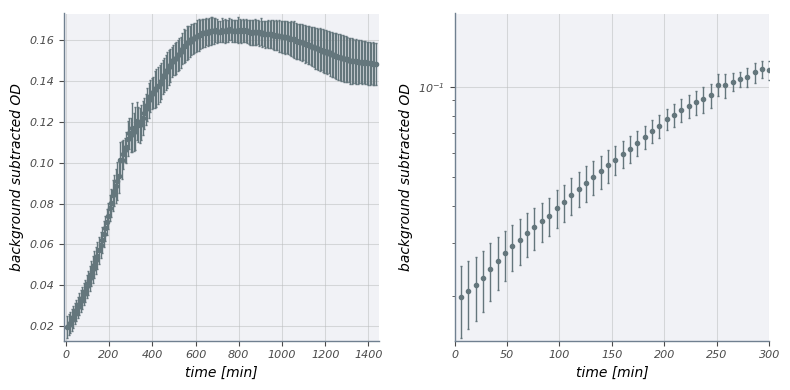

In [153]:
# Plot the growth data. 
grouped = data[data['strain']=='dilution'].groupby(['time_min']).agg(('mean', 'std')).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].set_xlabel('time [min]', fontsize=10)
    ax[i].set_ylabel('background subtracted OD', fontsize=10)

ax[1].set_yscale('log')
ax[1].set_xlim([0, 300])
ax[0].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
ax[1].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
plt.tight_layout()
plt.savefig('/Users/gchure/biotek_plate_reader.pdf')

 Using the data between 100 and 400 min, determine the exponential growth rate

In [49]:
# Restrict to the desired range
restricted = data[(data['strain']=='dilution') & (data['time_min'] >= 0) & (data['time_min'] <= 100)].copy()

Text(0, 0.5, 'background subtracted absorbance')

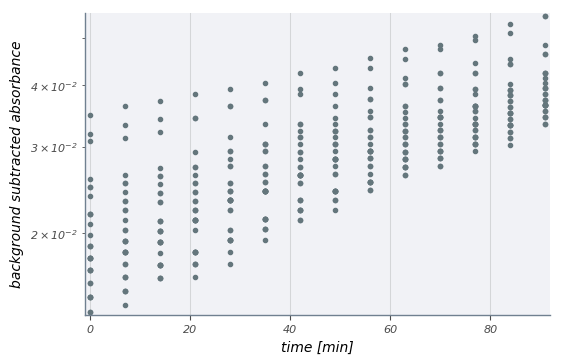

In [50]:
# Correct the time
restricted['time_min'] -= restricted['time_min'].min()

# Plot all of the data
fig, ax = plt.subplots(1, 1)
ax.semilogy(restricted['time_min'], restricted['od_sub'], '.')
ax.set_xlabel('time [min]', fontsize=10)
ax.set_ylabel('background subtracted absorbance', fontsize=10)

In [37]:
%%stan -v exp_growth
data {
    int<lower=0> N;
    real<lower=0> time[N];
    real<lower=0> absorb[N];
}

transformed data {
    real log_abs[N] = log(absorb);
}
parameters {
    real<lower=0> A_0;
    real<lower=0> lambda;
    real<lower=0> sigma;
}

model {
    A_0 ~ normal(0, 0.1);
    lambda ~ normal(0, 100);
    sigma ~ normal(0, 0.1);
    for (i in 1:N) {
        log_abs[i] ~ normal(log(A_0) + time[i] / lambda, sigma); 
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in exp_growth object.
Type exp_growth in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^
Access model compile output properties
exp_growth.model_file -> Name of stan_file [None]
exp_growth.model_name -> Name of stan model [None]
exp_growth.model_code -> Model code [data {     int<lower ....]


In [ ]:
model = pystan.StanModel(model_code=exp_growth.model_code)

In [111]:
growth_rates = []
growth_hpd_min = []
growth_hpd_max = []
for i in tqdm.tqdm(range(10, 600, 10)):
    restricted = data[(data['strain']=='dilution') & (data['time_min'] >= 0) & (data['time_min'] <= i)].copy()
    data_dict = {'N': len(restricted),
              'time': restricted['time_min'],
              'absorb': restricted['od_600nm']}
    samples = model.sampling(data_dict, iter=5000, control=dict(adapt_delta=0.95))
    samp_df = samples.to_dataframe()
    growth_rates.append(np.median(samp_df['lambda']))
    hpd_min, hpd_max = mwc.stats.compute_hpd(samp_df['lambda'], 0.95)
    growth_hpd_min.append(hpd_min) 
    growth_hpd_max.append(hpd_max)



100%|██████████| 59/59 [10:25<00:00, 22.17s/it]


In [112]:
t_double = np.log(2) * np.array(growth_rates)
t_double_min = np.log(2) * np.array(growth_hpd_min)
t_double_max = np.log(2) * np.array(growth_hpd_max)

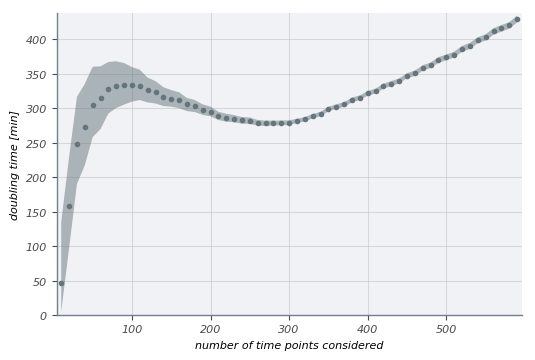

In [113]:
fig, ax = plt.subplots(1, 1)
t = np.arange(10, 600, 10)
ax.plot(t, t_double, '.')
ax.fill_between(t, t_double_min, t_double_max, alpha=0.5)
ax.set_ylabel('doubling time [min]')
ax.set_xlabel('number of time points considered')
plt.savefig('./time_dependence_inference_unsubtracted_abs.pdf')

In [144]:
restricted = data[(data['strain']=='dilution') & (data['time_min'] >= 0) & (data['time_min'] <= 300)].copy()
t_double = []
t_double_max = []
t_double_min = []
for g, d in tqdm.tqdm(restricted.groupby(['well_id'])):
    data_dict = {'N': len(d),
              'time': d['time_min'],
              'absorb': d['od_sub']}
    samples = model.sampling(data_dict, iter=2000, control=dict(adapt_delta=0.95))
    samp_df = samples.to_dataframe()
    growth_rate_median = np.median(samp_df['lambda'])
    hpd_min, hpd_max = mwc.stats.compute_hpd(samp_df['lambda'], 0.95)
    t_double.append(np.log(2) * growth_rate_median)
    t_double_max.append(np.log(2) * hpd_min)
    t_double_min.append(np.log(2) * hpd_max)

100%|██████████| 32/32 [00:14<00:00,  2.31it/s]


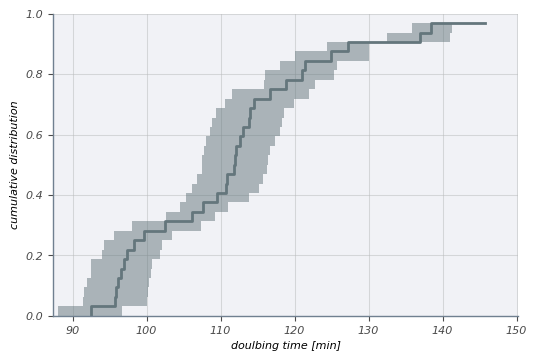

In [145]:
x_median = np.sort(t_double)
x_max = np.sort(t_double_max)
x_min = np.sort(t_double_min)
y = np.arange(0, len(t_double), 1)/len(x_median)
plt.step(x_median, y)
plt.fill_betweenx(y, x_min, x_max, alpha=0.5, step='post')
plt.ylim([0, 1])
plt.xlabel('doulbing time [min]')
plt.ylabel('cumulative distribution')
plt.savefig('output/cumulative_dist_t_double.pdf')
# plt.xlim([100, 110])

##  Using Gaussian Processes to Infer Growth Rates

In [146]:
delta = data[(data['strain']=='dilution') & (data['time_min'] < 400)]

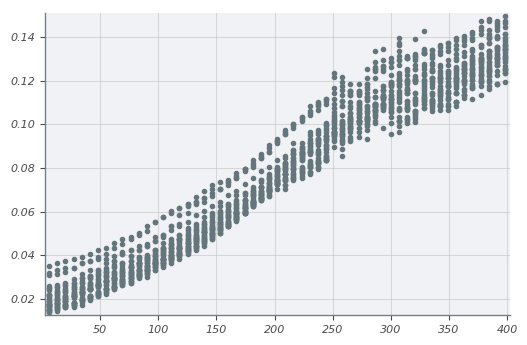

In [147]:
plt.plot(delta['time_min'], delta['od_sub'], '.')

Using the package [`fitderiv`](http://swainlab.bio.ed.ac.uk/software/fitderiv/) from Peter Swain's lab, we can perform non-parametric inference of the time-dependent growth rates of these data

In [148]:
gp = mwc.fitderiv.fitderiv(delta['time_min'].values, delta['od_sub'].values)

Taking natural logarithm of the data.
Fitting measurement errors.
Using a squared exponential Gaussian process.
hparam[0] determines the amplitude of variation
hparam[1] determines the flexibility
hparam[2] determines the variance of the measurement error
log(max likelihood)= 1.288449e+03
hparam[0]= 6.854837e+00 [1.000000e-05, 1.000000e+05]
hparam[1]= 2.862631e-05 [1.000000e-06, 1.000000e+02]
hparam[2]= 1.385295e-02 [1.000000e-05, 1.000000e+02]

Calculating statistics with 100 samples
	(displaying mean +/- standard deviation [standard error])

         max df= 8.769587e-03 +/- 6.120838e-04 [6.120838e-05]
 time of max df= 1.071667e+01 +/- 9.411031e+00 [9.411031e-01]
 inverse max df= 7.941322e+01 +/- 5.370474e+00 [5.370474e-01]
          max y= 1.338764e-01 +/- 1.874201e-03 [1.874201e-04]
       lag time= 6.216813e+00 +/- 1.641192e-01 [1.641192e-02]
